In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate,GlobalAveragePooling2D,Multiply,
    Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, precision_recall_curve, auc

import seaborn as sns
import os
import random
import csv
import cv2


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:


def collect_images_recursively(base_folder):
    """
    Recursively collect image paths from all subdirectories.
    """
    image_paths = []
    for root, _, files in os.walk(base_folder):
        for file in sorted(files):
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Add more formats if needed
                image_paths.append(os.path.join(root, file))
    return image_paths

def prepare_dataset(real_faces_folder, real_flow_folder, fake_faces_folder, fake_flow_folder, output_csv):
    """
    Prepare a CSV dataset mapping spatial frames (cropped faces) and optical flow images with labels
    for real and fake data.
    """
    dataset = []

    def process_real_data(cropped_faces_folder, optical_flow_folder, label):
        """
        Process real data, filtering only subdirectories containing "uniform" and "camera_front".
        """
        print("[INFO] Processing real data...")
        for subdir_name in sorted(os.listdir(cropped_faces_folder)):
            # if "uniform" not in subdir_name or "camera_front" not in subdir_name:
            #     continue

            subdir_path = os.path.join(cropped_faces_folder, subdir_name)
            flow_path = os.path.join(optical_flow_folder, subdir_name)

            if not os.path.isdir(subdir_path) or not os.path.isdir(flow_path):
                continue

            spatial_frames = collect_images_recursively(subdir_path)
            optical_flows = collect_images_recursively(flow_path)

            for frame, flow in zip(spatial_frames, optical_flows):
                dataset.append([frame, flow, label])

    def process_fake_data(cropped_faces_folder, optical_flow_folder, label):
        """
        Process fake data, filtering only subdirectories where the first three characters
        of the name after "end_to_end" are numeric and less than 101.
        """
        print("[INFO] Processing fake data...")
        for root, dirs, files in os.walk(cropped_faces_folder):
            if "end_to_end" not in root:
                continue

            # Extract the part after "end_to_end"
            parts = root.split("end_to_end")[-1].strip(os.sep).split(os.sep)
            print(f"[DEBUG] Current root: {root}")
            print(f"[DEBUG] Parts after 'end_to_end': {parts}")
            
            # if len(parts) < 1:
            #     print("[DEBUG] Skipping: No valid parts after 'end_to_end'.")
            #     continue
            
            # Get the first subdirectory name and split to extract the numeric prefix
            # first_part = parts[0]
            # numeric_prefix = first_part.split("_")[0]
            
            # if not numeric_prefix.isdigit():
            #     print(f"[DEBUG] Skipping: Prefix '{numeric_prefix}' is not numeric.")
            #     continue
            
            # if int(numeric_prefix) >= 200:
            #     print(f"[DEBUG] Skipping: Prefix '{numeric_prefix}' >= 101.")
            #     continue

            # Construct the corresponding optical flow folder
            relative_path = os.path.relpath(root, cropped_faces_folder)
            flow_path = os.path.join(optical_flow_folder, relative_path)
            
            if not os.path.isdir(flow_path):
                print(f"[DEBUG] Skipping: Optical flow folder does not exist for {root}.")
                continue

            # Recursively collect images
            spatial_frames = collect_images_recursively(root)
            optical_flows = collect_images_recursively(flow_path)

            for frame, flow in zip(spatial_frames, optical_flows):
                dataset.append([frame, flow, label])

    # Process real data
    process_real_data(real_faces_folder, real_flow_folder, label=0)

    # Process fake data
    process_fake_data(fake_faces_folder, fake_flow_folder, label=1)

    # Shuffle and save to CSV
    print(f"[INFO] Total dataset size before shuffling: {len(dataset)}")
    random.shuffle(dataset)
    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["spatial_frame", "optical_flow", "label"])  # Header
        writer.writerows(dataset)
    print(f"[INFO] CSV saved to: {output_csv}")

# Define paths
real_faces = "E:/Research/real/Cropped_Faces"
real_flow = "E:/Research/real/Optical_Flow"
fake_faces = "E:/Research/fake/Cropped_Faces"
fake_flow = "E:/Research/fake/Optical_Flow"
output_csv = "angry_dataset_real_fake_filtered.csv"

# Prepare the dataset
prepare_dataset(real_faces, real_flow, fake_faces, fake_flow, output_csv)
print("[INFO] Dataset preparation complete.")


[INFO] Processing real data...
[INFO] Processing fake data...
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end
[DEBUG] Parts after 'end_to_end': ['']
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\711_M007
[DEBUG] Parts after 'end_to_end': ['711_M007']
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\023_M113
[DEBUG] Parts after 'end_to_end': ['023_M113']
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\759_W025
[DEBUG] Parts after 'end_to_end': ['759_W025']
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\952_W101
[DEBUG] Parts after 'end_to_end': ['952_W101']
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\351_M023
[DEBUG] Parts after 'end_to_end': ['351_M023']
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\837_W037
[DEBUG] Parts after 'end_to_end': ['837_W037']
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\974_M038
[DEBUG] Parts after 'end_to_end': ['974_M0

In [4]:
# Define CNN for spatial and temporal feature extraction with L2 regularization
def create_cnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return inputs, x

# Spatial feature extractor
spatial_input, spatial_features = create_cnn((256, 256, 3))  # RGB input

# Temporal feature extractor
temporal_input, temporal_features = create_cnn((256, 256, 3))  # Optical flow input

# Align spatial and temporal features
spatial_features = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(spatial_features)
temporal_features = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(temporal_features)

# Combine features
combined = concatenate([spatial_features, temporal_features])

# Fully connected layers with Dropout
x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(combined)
x = Dropout(0.5)(x)  # Dropout added here
x = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Dropout added here
x = Dense(1, activation="sigmoid")(x)

# Model
model = Model(inputs=[spatial_input, temporal_input], outputs=x)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"], run_eagerly=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                             

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # Ensure compatibility with Keras Sequence API
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch = [self.data[i] for i in batch_indexes]
        
        spatial_frames = []
        optical_flows = []
        labels = []
        for row in batch:
            spatial_frame_path = row[0]
            optical_flow_path = row[1]
            label = row[2]
    
            spatial_frame = cv2.imread(spatial_frame_path)
            optical_flow = cv2.imread(optical_flow_path)
    
            if spatial_frame is None or optical_flow is None:
                print(f"[WARNING] Missing file(s): {spatial_frame_path} or {optical_flow_path}")
                continue
            
            spatial_frame = cv2.resize(spatial_frame, (256, 256))
            optical_flow = cv2.resize(optical_flow, (256, 256))
    
            spatial_frames.append(spatial_frame / 255.0)
            optical_flows.append(optical_flow / 255.0)
            labels.append(label)
    
        spatial_frames = np.array(spatial_frames, dtype="float32")
        optical_flows = np.array(optical_flows, dtype="float32")
        labels = np.array(labels, dtype="float32").reshape(-1, 1)
        
        spatial_frames = tf.convert_to_tensor(spatial_frames)
        optical_flows = tf.convert_to_tensor(optical_flows)
        labels = tf.convert_to_tensor(labels)
        
        return (spatial_frames, optical_flows), labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def reset(self):
        """Reset the generator to start from the beginning."""
        self.indexes = np.arange(len(self.data))  # Reset indexes
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [6]:
# Load the dataset from CSV
dataset = pd.read_csv("angry_dataset_real_fake_filtered.csv").values

# Split into training and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [7]:
# Example batch test
train_gen = DataGenerator(train_data, batch_size=2)
# Example batch test
inputs, labels_batch = train_gen[0]
spatial_batch, temporal_batch = inputs

# Enforce correct label shape
labels_batch = labels_batch.numpy().reshape(-1, 1)  # Convert to NumPy and reshape
print(f"Spatial batch shape: {spatial_batch.shape}")
print(f"Temporal batch shape: {temporal_batch.shape}")
print(f"Labels batch shape: {labels_batch.shape}")


Spatial batch shape: (2, 256, 256, 3)
Temporal batch shape: (2, 256, 256, 3)
Labels batch shape: (2, 1)


In [10]:
# Load the dataset from the CSV file
dataset = pd.read_csv("angry_dataset_real_fake_filtered.csv").values

# Split into training and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Initialize data generators
train_gen = DataGenerator(train_data, batch_size=32)
val_gen = DataGenerator(val_data, batch_size=32)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=3,          # Stop training after 3 epochs with no improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

# Learning Rate Scheduler Callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",  # Monitor validation loss
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    patience=2,           # Wait 2 epochs before reducing the learning rate
    min_lr=1e-6, 
    verbose=1
)

# Model Checkpoint Callback to save the best model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="angry_expression_model_best.h5",  # Filepath to save the best model
    monitor="val_loss",  # Monitor validation loss
    save_best_only=True,  # Save only when the monitored metric improves
    save_weights_only=False,  # Save the full model
    mode="min",  # Minimize validation loss
    verbose=1  # Print log when saving
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                             

In [11]:

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,  # Set to 1 for detailed logs
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]  # Include callbacks
)

print("[INFO] Model training completed. Best model saved as 'angry_expression_model_best.h5'.")

Epoch 1/10
47968/47968 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9891
Epoch 1: val_loss improved from inf to 0.03450, saving model to angry_expression_model_best.h5
47968/47968 [==============================] - 26515s 553ms/step - loss: 0.1793 - accuracy: 0.9891 - val_loss: 0.0345 - val_accuracy: 0.9963 - lr: 0.0010
Epoch 2/10
47968/47968 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9957
Epoch 2: val_loss improved from 0.03450 to 0.02605, saving model to angry_expression_model_best.h5
47968/47968 [==============================] - 24815s 517ms/step - loss: 0.0420 - accuracy: 0.9957 - val_loss: 0.0261 - val_accuracy: 0.9984 - lr: 0.0010
Epoch 3/10
47968/47968 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9962
Epoch 3: val_loss did not improve from 0.02605
47968/47968 [==============================] - 26244s 547ms/step - loss: 0.0383 - accuracy: 0.9962 - val_loss: 0.0286 - val_accuracy: 0.9984 - lr: 0.00

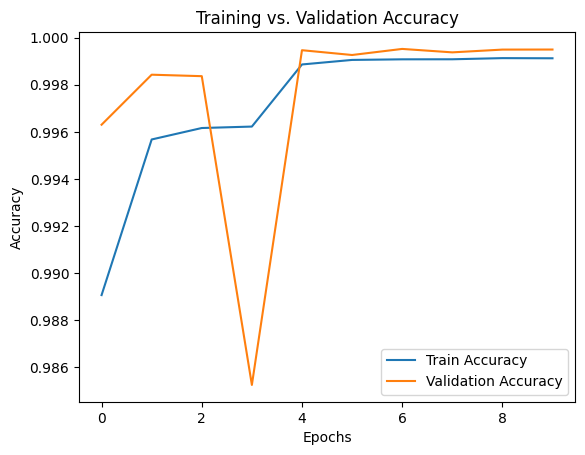

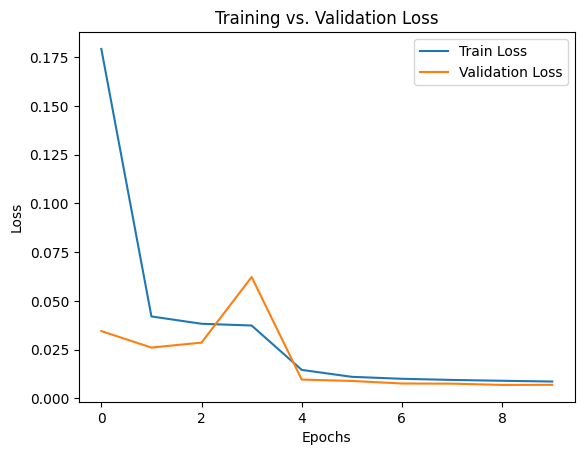

In [12]:

# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Validation Accuracy")
plt.show()

# Plot training and validation loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()

In [13]:


val_gen = DataGenerator(val_data, batch_size=64)

# Verify DataGenerator output
(spatial_frames, optical_flows), labels = val_gen[0]
print("Model input shape:", model.input_shape)
print("Spatial Frames Shape:", spatial_frames.shape)
print("Optical Flows Shape:", optical_flows.shape)
print("Labels Shape:", labels.shape)

# Step 3: Generate Predictions
val_predictions = model.predict(val_gen)
val_probabilities = val_predictions.flatten()  # Flatten probabilities to 1D array
val_predictions = (val_probabilities > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 4: Extract Ground Truth Labels
val_labels = []


Model input shape: [(None, 256, 256, 3), (None, 256, 256, 3)]
Spatial Frames Shape: (64, 256, 256, 3)
Optical Flows Shape: (64, 256, 256, 3)
Labels Shape: (64, 1)
5996/5996 [==============================] - 5224s 871ms/step


Accuracy Score: 0.5099
ROC AUC Score: 0.5010
Recall Score: 0.5678
Precision Score: 0.5678
PR AUC Score: 0.6767


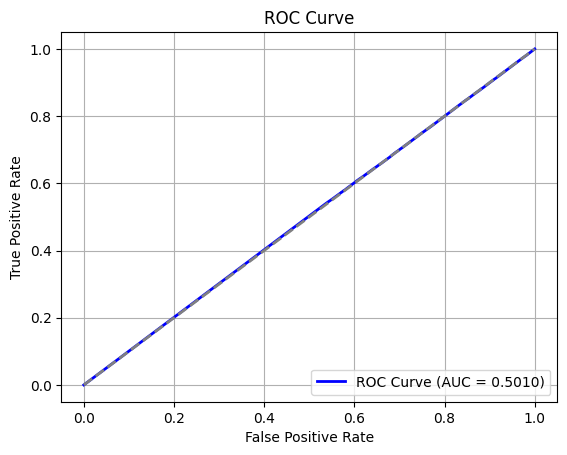

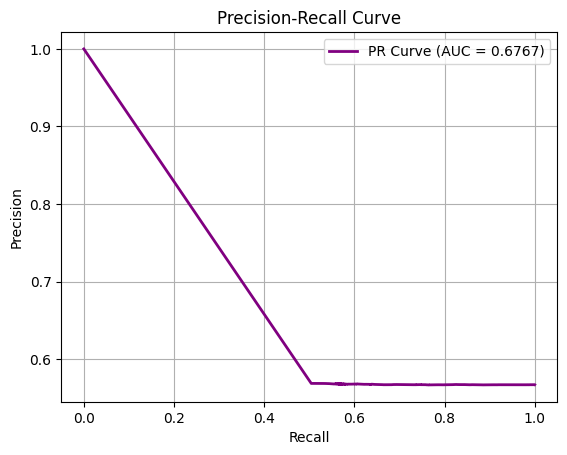

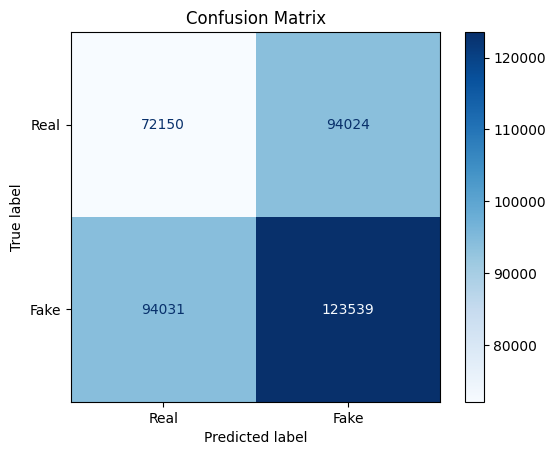

In [14]:
val_gen.reset()  # Ensure correct sequence in generator
for _, batch_labels in val_gen:
    val_labels.extend(batch_labels.numpy().flatten())
    if len(val_labels) >= len(val_predictions):
        break
val_labels = np.array(val_labels[:len(val_predictions)])  # Match predictions length

# Step 5: Evaluate Metrics
accuracy = accuracy_score(val_labels, val_predictions)
roc_auc = roc_auc_score(val_labels, val_probabilities)
recall = recall_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(val_labels, val_probabilities)
pr_auc = auc(recall_vals, precision_vals)

# Print Metrics
print(f"Accuracy Score: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

# Step 6: Visualize Metrics
# ROC Curve
fpr, tpr, thresholds = roc_curve(val_labels, val_probabilities)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Precision-Recall Curve
plt.figure()
plt.plot(recall_vals, precision_vals, color='purple', lw=2, label=f"PR Curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()